<a href="https://colab.research.google.com/github/Alexandr-M-85/Neural-University/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%9D%D0%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание Ultra pro**

Загрузите базу смс-сообщений, разделенных по категориям спам и не спам.

Создайте обучающую, проверочную выборки. Создайте и обучите модель, определяющую тип сообщения. Классифицируйте каждое сообщение. Чтобы было легче, каждое сообщение переделайте в последовательность токенов,и ограничьте или добейте нулями до определённой длины - 15.

Возьмите 10 случайных примеров из всей базы, сделайте предсказание нейронкой и выведите результат в читаемом виде:

“текст сообщения” - “категория сообщения, определенная нейронкой”.

Постройте диаграмму частотности распределения слов(plt.stem()) в нормальных сообщениях и сообщениях со спамом.

In [ ]:
#импорт библиотек
import random
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Embedding, Activation, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#загрузка данных в датафрейм
df = pd.read_csv(open('/content/drive/MyDrive/data/psy.csv', errors='replace'))
df

,comment_id,author,date,content,class
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",True
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,True
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,True
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,True
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,True
...,...,...,...,...,...
345,z13th1q4yzihf1bll23qxzpjeujterydj,Carmen Racasanu,2014-11-14T13:27:52,How can this have 2 billion views when there's...,False
346,z13fcn1wfpb5e51xe04chdxakpzgchyaxzo0k,diego mogrovejo,2014-11-14T13:28:08,I don't now why I'm watching this in 2014﻿,False
347,z130zd5b3titudkoe04ccbeohojxuzppvbg,BlueYetiPlayz -Call Of Duty and More,2015-05-23T13:04:32,subscribe to me for call of duty vids and give...,True
348,z12he50arvrkivl5u04cctawgxzkjfsjcc4,Photo Editor,2015-06-05T14:14:48,hi guys please my android photo editor downloa...,True


In [ ]:
#уберем лишние столбцы
df = df.iloc[:,-2:]
df

,content,class
0,"Huh, anyway check out this you[tube] channel: ...",True
1,Hey guys check out my new channel and our firs...,True
2,just for test I have to say murdev.com,True
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,True
4,watch?v=vtaRGgvGtWQ Check this out .﻿,True
...,...,...
345,How can this have 2 billion views when there's...,False
346,I don't now why I'm watching this in 2014﻿,False
347,subscribe to me for call of duty vids and give...,True
348,hi guys please my android photo editor downloa...,True


# Подготовка данных

In [ ]:
#проверим сколько записей каждого класса
for cl in df['class'].unique():
  print('Количество записей', cl, ':', df[df['class'] == cl].shape[0])

Количество записей True : 175
Количество записей False : 175


In [ ]:
#извлечем все текстовые данные из столбца content
texts = df['content'].values
#извлечем соответствующие им значения классов
classes = list(df['class'].values)

In [ ]:
#зададим максимальное количество слов, учитываемое при обучении текстов
maxWordsCount = 700

In [ ]:
#Зададим количество классов
nClasses = df['class'].nunique()
print('Количество классов:', nClasses)

Количество классов: 2


In [ ]:
#преобразуем текстовые данные в числовые
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', oov_token='unknown')
#соберем словарь частотности
tokenizer.fit_on_texts(texts)

In [ ]:
#посмотрим индексы слов и размер словаря
print(tokenizer.word_index.items())
print("Размер словаря:", len(tokenizer.word_index.items()), 'слов')

dict_items([('unknown', 1), ('the', 2), ('to', 3), ('i', 4), ('and', 5), ('this', 6), ('my', 7), ('you', 8), ('http', 9), ('a', 10), ('views', 11), ('check', 12), ('is', 13), ('com', 14), ('2', 15), ('www', 16), ('of', 17), ('out', 18), ('subscribe', 19), ('on', 20), ('me', 21), ('it', 22), ('channel', 23), ('please', 24), ('video', 25), ('like', 26), ('for', 27), ('billion', 28), ('so', 29), ('in', 30), ('if', 31), ('have', 32), ('https', 33), ('just', 34), ('song', 35), ('youtube', 36), ('get', 37), ('can', 38), ('are', 39), ('be', 40), ('people', 41), ('here', 42), ('how', 43), ('d', 44), ('that', 45), ('amp', 46), ('music', 47), ('1', 48), ('image2you', 49), ('ru', 50), ('48051', 51), ('not', 52), ('guys', 53), ('only', 54), ('new', 55), ('videos', 56), ('what', 57), ('we', 58), ('at', 59), ('psy', 60), ('will', 61), ('they', 62), ('there', 63), ('do', 64), ('3', 65), ('has', 66), ('hey', 67), ('but', 68), ('facebook', 69), ('your', 70), ('money', 71), ('even', 72), ('thanks', 73),

In [ ]:
#преобразуем тексты сообщений в последовательность индексов согласно частотному словарю
textsWordIndexes = tokenizer.texts_to_sequences(texts)
print("Оригинальный текст:", texts[0])
print("Он же в виде последовательности индексов: ", textsWordIndexes[0])

Оригинальный текст: Huh, anyway check out this you[tube] channel: kobyoshi02
Он же в виде последовательности индексов:  [521, 321, 12, 18, 6, 8, 522, 23, 523]


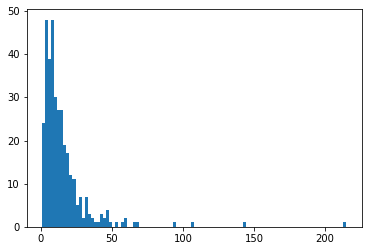

In [ ]:
#посмотрим на длины сообщений
lenTexts = [len(x) for x in textsWordIndexes]
plt.hist(lenTexts, 100)
plt.show()

In [ ]:
#каждое сообщение ограничим или добьем нулями до определенной длины - 15 слов
maxLen = 15
textsWordIndexes = pad_sequences(textsWordIndexes, maxlen=maxLen)
textsWordIndexes[0]

array([  0,   0,   0,   0,   0,   0, 521, 321,  12,  18,   6,   8, 522,
        23, 523], dtype=int32)

In [ ]:
#сформируем матрицу индексов
xAll = tokenizer.sequences_to_matrix(textsWordIndexes.tolist())
print(xAll.shape)
print(xAll[0])

(350, 700)
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 

In [ ]:
#преобразуем классы в векторы
encoder = LabelEncoder()
encoder.fit(classes)
classesEncoded = encoder.transform(classes)
print(encoder.classes_)
print(classesEncoded.shape)
print(classesEncoded)

[False  True]
(350,)
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1
 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0
 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0]


In [ ]:
yAll = utils.to_categorical(classesEncoded, nClasses)
print(yAll.shape)

(350, 2)


In [ ]:
#разбиваем данные на обучающую и тестовую выборки
xTrain, xTest, yTrain, yTest = train_test_split(xAll, yAll, test_size=0.2, shuffle = True)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(280, 700)
(280, 2)
(70, 700)
(70, 2)


# Нейросеть

In [ ]:
#нейросеть

#создаем полносвязную сеть
model = Sequential()
#первый полносвязный слой
model.add(Dense(64, input_dim=maxWordsCount, activation='relu'))
#слой регуляризации Dropout
model.add(Dropout(0.4))
#выходной полносвязный слой
model.add(Dense(nClasses, activation='sigmoid'))

#компилируем модель
model.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#обучаем сеть
history = model.fit(xTrain, yTrain, epochs=20, batch_size=32, validation_data=(xTest, yTest))

Epoch 1/20
9/9 [==============================] - 1s 25ms/step - loss: 0.6890 - accuracy: 0.5286 - val_loss: 0.6627 - val_accuracy: 0.6571
Epoch 2/20
9/9 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.7357 - val_loss: 0.6167 - val_accuracy: 0.8429
Epoch 3/20
9/9 [==============================] - 0s 4ms/step - loss: 0.5692 - accuracy: 0.8679 - val_loss: 0.5693 - val_accuracy: 0.9000
Epoch 4/20
9/9 [==============================] - 0s 5ms/step - loss: 0.4999 - accuracy: 0.9250 - val_loss: 0.5186 - val_accuracy: 0.9143
Epoch 5/20
9/9 [==============================] - 0s 5ms/step - loss: 0.4408 - accuracy: 0.9250 - val_loss: 0.4634 - val_accuracy: 0.9286
Epoch 6/20
9/9 [==============================] - 0s 5ms/step - loss: 0.3720 - accuracy: 0.9714 - val_loss: 0.4081 - val_accuracy: 0.9286
Epoch 7/20
9/9 [==============================] - 0s 5ms/step - loss: 0.3093 - accuracy: 0.9750 - val_loss: 0.3574 - val_accuracy: 0.9286
Epoch 8/20
9/9 [=================

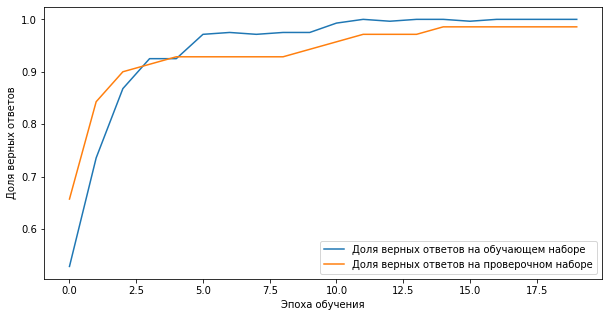

In [ ]:
#выведем график обучения
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

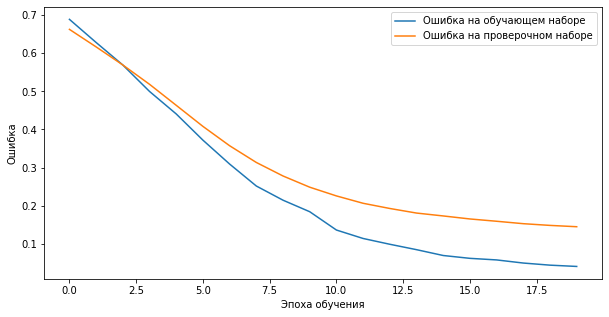

In [ ]:
#выведем график ошибок
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

# Проверка

In [ ]:
#возьмем 10 случайных примеров из всей базы, сделаем предсказание и выведем результат
for i in range(1, 11):
    x = random.randint(0, 349)
    print('Проверка №:', i)
    print('Текст сообщения:')
    print(df.iloc[x, -2])
    print('Категория сообщения:', df.iloc[x, -1])
    print('Категория сообщения определенная нейронкой:', end=' ')
    if np.argmax(model.predict(xAll)[x]) == 0:
        print('False')
    else:
        print('True')
    if df.iloc[x, -1] == np.argmax(model.predict(xAll)[x]):
        print('ВЕРНО!')
    else:
        print('ОШИБКА!')
    print()

Проверка №: 1
Текст сообщения:
Im just to check how much views it has﻿
Категория сообщения: False
Категория сообщения определенная нейронкой: False
ВЕРНО!

Проверка №: 2
Текст сообщения:
The girl in the train who was dancing, her outfit was so fucking sexy, but  the huge turn-off was she lacked eyebrows D:﻿
Категория сообщения: False
Категория сообщения определенная нейронкой: False
ВЕРНО!

Проверка №: 3
Текст сообщения:
I hate this song! ﻿
Категория сообщения: False
Категория сообщения определенная нейронкой: False
ВЕРНО!

Проверка №: 4
Текст сообщения:
i check back often to help reach 2x10^9 views and I avoid watching Baby﻿
Категория сообщения: False
Категория сообщения определенная нейронкой: False
ВЕРНО!

Проверка №: 5
Текст сообщения:
just for test I have to say murdev.com
Категория сообщения: True
Категория сообщения определенная нейронкой: True
ВЕРНО!

Проверка №: 6
Текст сообщения:
now its 1,884,034,783 views! pls. comment the view count the next hour :P﻿
Категория сообщения: F

# Визуализация

In [ ]:
#разделим сообщения разделенные по категориям для построения диаграммы частотности распределения слов 
dfTrue = df[df['class']==True]
dfFalse = df[df['class']==False]

In [ ]:
#извлечем все текстовые данные из столбца content
textsTrue = dfTrue['content'].values
textsFalse = dfFalse['content'].values

In [ ]:
#преобразуем текстовые данные в числовые
tokenizerTrue = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', oov_token='unknown')
tokenizerFalse = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', oov_token='unknown')
#соберем словари частотности
dictTrue = tokenizerTrue.fit_on_texts(textsTrue)
dictFalse = tokenizerFalse.fit_on_texts(textsFalse)

In [ ]:
#соберем все слова в словари
newDictTrue = dict(tokenizerTrue.word_counts)
newDictFalse = dict(tokenizerFalse.word_counts)
#отсортируем словари по частотности встречающихся слов по убыванию
sortedDictTrue = sorted(newDictTrue.items(), key=lambda x: x[1], reverse=True)
sortedDictFalse = sorted(newDictFalse.items(), key=lambda x: x[1], reverse=True)
print(sortedDictTrue)
print(sortedDictFalse)

[('my', 81), ('and', 69), ('i', 69), ('to', 68), ('http', 63), ('com', 53), ('www', 51), ('you', 49), ('check', 47), ('subscribe', 46), ('channel', 43), ('out', 41), ('please', 41), ('me', 39), ('the', 36), ('a', 36), ('like', 30), ('for', 30), ('https', 29), ('if', 25), ('on', 23), ('of', 22), ('amp', 20), ('image2you', 20), ('ru', 20), ('48051', 20), ('have', 19), ('guys', 18), ('it', 18), ('videos', 17), ('so', 17), ('can', 17), ('get', 16), ('new', 15), ('be', 15), ('do', 14), ('facebook', 14), ('thanks', 14), ('this', 13), ('hey', 13), ('is', 13), ('music', 13), ('will', 12), ('free', 12), ('plz', 12), ('our', 11), ('here', 11), ('money', 11), ('in', 10), ('follow', 10), ('everyone', 10), ('not', 9), ('at', 9), ('your', 9), ('sub', 9), ('youtube', 9), ('go', 9), ('co', 9), ("don't", 9), ('just', 8), ('that', 8), ('we', 8), ('video', 8), ('gift', 8), ('comment', 7), ('about', 7), ('d', 7), ('what', 7), ('one', 7), ('twitter', 7), ('but', 7), ('would', 7), ('some', 7), ('come', 7), 

In [ ]:
#преобразуем обратно в формат словаря и возьмем 50 самых часто встречающихся слов
sortedDictTrue = dict(sortedDictTrue[:50])
sortedDictFalse = dict(sortedDictFalse[:50])

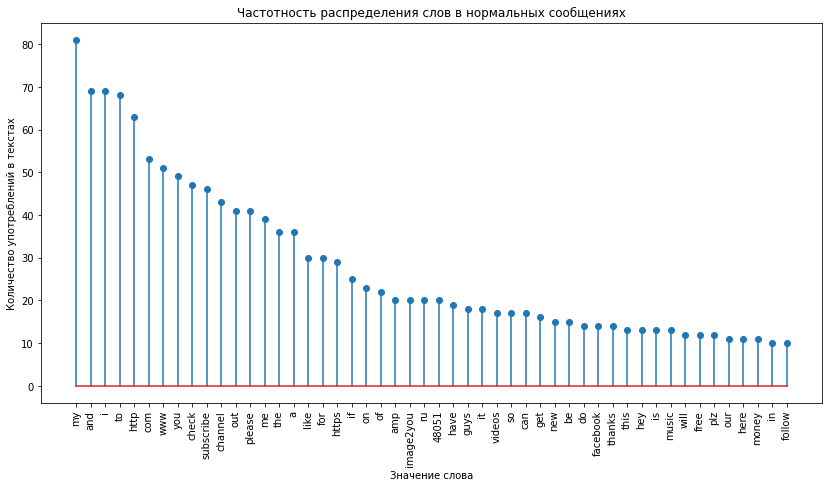

In [ ]:
#выведем диаграмму частотности распределения слов в нормальных сообщениях
plt.figure(figsize=(14,7))
x = sortedDictTrue.keys()
y = sortedDictTrue.values()
plt.xticks(rotation=90)
plt.xlabel('Значение слова')
plt.ylabel('Количество употреблений в текстах')
plt.title('Частотность распределения слов в нормальных сообщениях')
plt.stem(x, y)
plt.show()

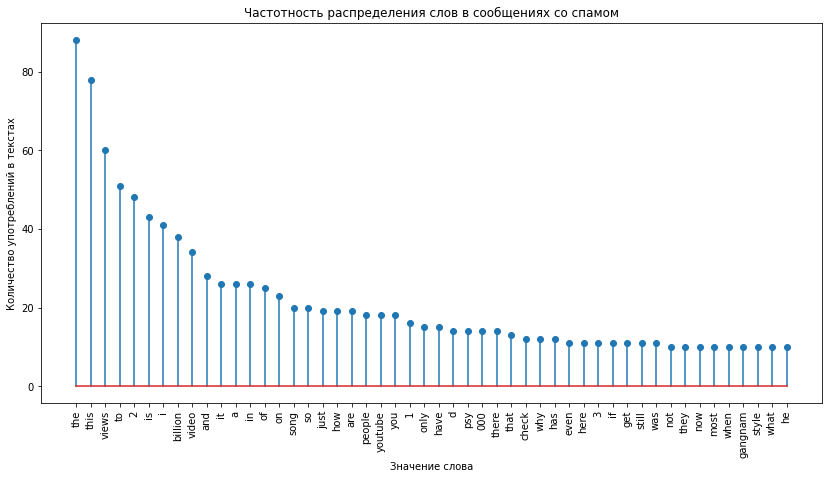

In [ ]:
#выведем диаграмму частотности распределения слов в сообщениях со спамом
plt.figure(figsize=(14,7))
x = sortedDictFalse.keys()
y = sortedDictFalse.values()
plt.xticks(rotation=90)
plt.xlabel('Значение слова')
plt.ylabel('Количество употреблений в текстах')
plt.title('Частотность распределения слов в сообщениях со спамом')
plt.stem(x, y)
plt.show()